## Load Data 

In [1]:
from data import Images_load

In [2]:
train, validation, test = Images_load.load_data()

Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.


100%|██████████| 4192/4192 [00:10<00:00, 386.32it/s]


In [3]:
train.features.shape

(4611, 224, 224, 3)

# ResNet 50 transfer learning: 

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input


In [9]:
def _prepare_data(train, validation, test):
    """
    Prepare datasets of images for CNN
    :param train:
    :param validation:
    :param test:
    :return:
    """
    features, y_train = train.features, train.labels
    featuresV, y_val = validation.features, validation.labels
    featuresT, y_test = test.features, test.labels
    x_train = np.stack(features)
    x_val = np.stack(featuresV)
    x_test = np.stack(featuresT)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_val = x_val.astype('float32')
    x_val /= 255
    x_train /= 255
    x_test /= 255

    return x_train, y_train, x_test, y_test, x_val, y_val

In [11]:
import numpy as np
x_train, y_train, x_test, y_test, x_val, y_val=_prepare_data(train,validation,test)

In [12]:
# Load ResNet50 Trained on imagenet
resnet_model = ResNet50(weights="imagenet")


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

102858752/102853048 [==============================] - 9s 0us/step


In [20]:
# We should preprocess the images the same way resnet images were preprocessed
x_train_preprocessed = preprocess_input(x_train)
x_test_preprocessed = preprocess_input(x_test)
x_val_preprocess = preprocess_input(x_val)

In [16]:
# Build a new model that is ResNet50 minus the very last layer
last_layer = resnet_model.get_layer("avg_pool")

resnet_layers = keras.Model(inputs=resnet_model.inputs, outputs=last_layer.output)

In [30]:
# We can directly stich the models together

ResNet_adapt=Sequential()
ResNet_adapt.add(resnet_layers)
ResNet_adapt.add(Dense(2, activation="sigmoid"))

ResNet_adapt.layers[0].trainable=False # we are just going to tune the last layer weight the other weights inside of the resnet model will remain the same 

ResNet_adapt.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

ResNet_adapt.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 2048)              23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [31]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import TensorBoard
my_callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True),
        ModelCheckpoint(filepath='Resnet_transfer.{epoch:02d}-{val_loss:.2f}.h5',
                        monitor='val_accuracy', verbose=1,
                        save_best_only=True, mode='max'),
        TensorBoard(log_dir="logs", histogram_freq=0, write_graph=True, write_images=True)
    ]

In [32]:
%%time 
history=ResNet_adapt.fit(x_train_preprocessed, y_train, epochs=50, validation_data=(x_val_preprocess, y_val), callbacks=my_callbacks)

Train on 4611 samples, validate on 1538 samples
Epoch 1/50
4611/4611 [==============================] - 751s 163ms/step - loss: 0.5920 - accuracy: 0.6852 - val_loss: 1.1036 - val_accuracy: 0.4844

Epoch 00001: val_accuracy improved from -inf to 0.48440, saving model to Resnet_transfer.01-1.10.h5
Epoch 2/50
4611/4611 [==============================] - 733s 159ms/step - loss: 0.5507 - accuracy: 0.7224 - val_loss: 1.1658 - val_accuracy: 0.4844

Epoch 00002: val_accuracy did not improve from 0.48440
Epoch 3/50
4611/4611 [==============================] - 754s 164ms/step - loss: 0.5292 - accuracy: 0.7427 - val_loss: 1.2232 - val_accuracy: 0.4844
Restoring model weights from the end of the best epoch

Epoch 00003: val_accuracy did not improve from 0.48440
Epoch 00003: early stopping
CPU times: user 3h 11min 16s, sys: 1h 45min 28s, total: 4h 56min 45s
Wall time: 37min 30s


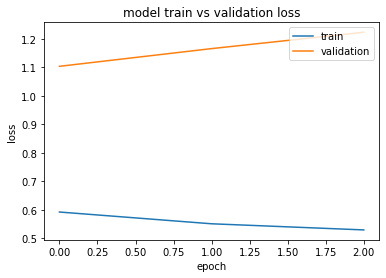

In [33]:
from matplotlib import pyplot
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show() # overfittinnng gued rassi 

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

In [39]:
score = ResNet_adapt.evaluate(x_train_preprocessed, y_train, verbose=2)
print('Train accuracy:', score[ 1 ])
    

Train accuracy: 0.4903491735458374
